# Test notebook for the representation part

## Paper implementation:
### Metadata label generator
- SVM
- Confusion-matrix
- superclass division based on confusion matrix
### Intelligent reasoning
- Metadata creation (OvO OvR)
- RandomForest Classifier

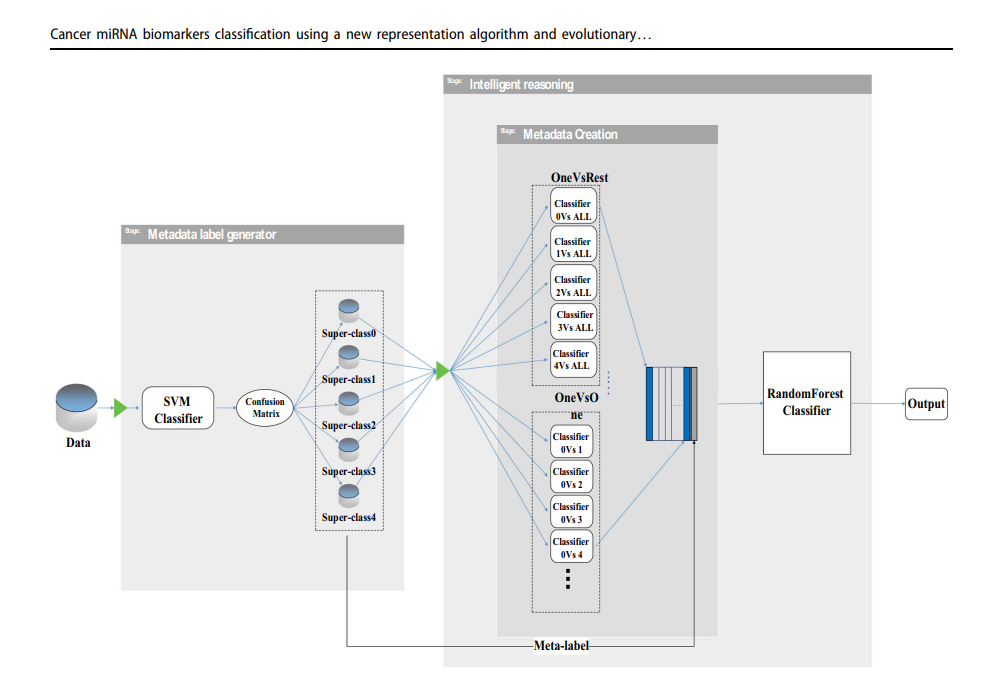

Fig. 4 Structure of meta-data classification

In [ ]:
#TODO: Normalize data before every classification (Paper uses Z-Norm)
#TODO: after normalization, divide in two groups which are train and test
# The training process is divided in 
## 1. Representation learning (intelligent reasoning on the paper)
## 2. Feature selection 
## 3. GA-CNN Classifier 

#RESULT: Obtain n models [CNN] (where n is the number of super classes)

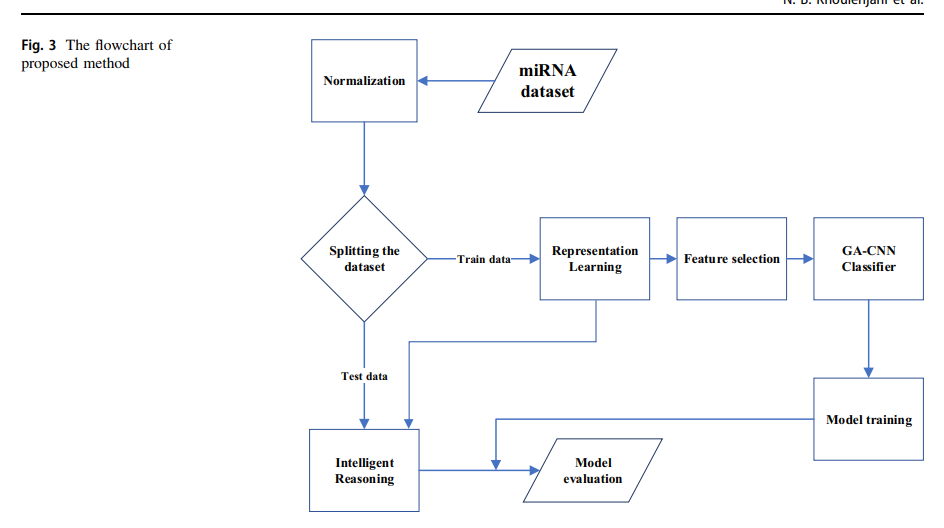

Metalabel generator:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils.utils import *
from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import scipy


#TODO: dataloader of data, normalization and split.

## Extract label and data 
label_path="data/MLinApp_course_data/tcga_mir_label.csv"
data_path="data/MLinApp_course_data/tcga_mir_rpm.csv"

miRna_label = extract_label(label_path)
miRna_data = np.genfromtxt(data_path, delimiter=',')[1:,0:-1]

In [ ]:
## Labeling process: removing the duplicates
label_idx, dictionary = label_processing(miRna_label)
labels = np.unique(miRna_label, return_counts=True)

lab = []
for i in range(len(labels[0])):
  lab.append((labels[0][i], labels[1][i], dictionary[labels[0][i]]))

lab.sort(key= lambda x: x[1])

print(labels[0])

In [ ]:
# Deleting all the data that came from TARGET-* labels
number_to_delete = abs(len(miRna_label) - miRna_data.shape[0])
miRna_data = miRna_data[number_to_delete:,:]

In [ ]:
# Z-score normalization
miRna_data = scipy.stats.zscore(miRna_data, axis=1)
assert np.isnan(miRna_data).sum() == 0

In [ ]:
# Splitting dataset in train and test using 60% train and 20% validation 20%evaluation
train_data, val_data, train_label, val_label = train_test_split(miRna_data, miRna_label, test_size=0.20, random_state=42)
train_data, eva_data, train_label, eva_label = train_test_split(train_data, train_label, test_size=0.25, random_state=42)

In [ ]:
n_classes = np.unique(train_label).size

print(n_classes)

In [ ]:
print("Training set dimensions: {}".format(train_data.shape))
print("Validation set dimensions: {}".format(val_data.shape))
print("Test set dimensions: {}".format(eva_data.shape))

print("\n")

print("Dimensions of a single sample: {}".format(train_data[0].shape))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#TODO: SVM prior-classification and superclass identification confusion matrix based.
#classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

random_grid_svm = {'kernel': ['rbf', 'poly', 'sigmoid'],
                   'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
                   'degree': [2,3,4,5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}

In [ ]:
search = RandomizedSearchCV(estimator=svm.SVC(),
                            param_distributions= random_grid_svm,
                            scoring='balanced_accuracy',
                            n_iter=10,
                            cv=3,
                            verbose=1,
                            random_state=42,
                            n_jobs=-1)

In [32]:
search.fit(train_data, train_label)
classifier = search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
val_pred = classifier.predict(val_data)
cm = confusion_matrix(val_label, val_pred, normalize="true")
cmp = ConfusionMatrixDisplay(cm, display_labels=labels[0])
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax)

#plt.show()

In [ ]:
#TODO: Superclass division
#train data -> miRna_data
#train label -> miRna_label

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 5 #superclass 0...4

In [ ]:
#TODO: Metadata creation (OvO - One v One + OvR - One v Rest) + Random Forest classification

